### X-axis Data Challenge

In [540]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import array
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import confusion_matrix,precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [541]:
dfo = pd.read_csv('./data/xaxis/train.csv')
dfo_test = pd.read_csv('./data/xaxis/test.csv')
#Look for duplicated rows and drop them
dfo = dfo.drop_duplicates()

#Some websites are NaN so dropping these
#df.dropna(inplace=True)
dfo['domain'].fillna('Unknown',inplace=True)

#Undersample the background to 60/40 ratio of non-click/click
df0 = dfo[(dfo['response']==0)]
df1 = dfo[dfo['response']==1]
print(len(df1))
seed = 5789
df0 = df0.sample(frac=0.008,random_state=seed)
print(len(df0))
df = pd.concat([df0,df1])
print(len(df))


491
702
1193


In [543]:
#Get Some info about df
Nsig=len(df[df['response']==1].index)
Nbkg=len(df[df['response']==0].index)
ratio=Nsig/(Nbkg+Nsig)
print(ratio)

0.4115674769488684


5% of the sample has a response =1. Hence, this is an unbalanced sample. I would choose to use LogisticRegression or RandomForestClassifier, as these are known to perform well and reduce false negatives

In [544]:
def getdict(data):
    data.loc[data['user_hour']>0,'user_hour']=1
    #data['user_day'][(data['user_day']>=0) & (data['user_day']<5)]=0
    #data['user_day'][data['user_day']>=5]=1
    
    
    #Group websites according to click through rate per user_hour (pertains to a view)
    #grouped = data.groupby(['domain','user_day'],as_index=False).agg({'user_hour':np.sum,'response':np.sum}).sort_values(by='response')
    #grouped['ctr']=grouped['response']/np.maximum(grouped['user_hour'],.001)

    grouped = df.groupby(['domain','user_day'],as_index=False).agg({'user_hour':np.sum})
    newgroup = grouped
    newgroup = newgroup.groupby(['domain'],as_index=False).agg({'user_hour':np.sum})
    grouped['weekviews'] = newgroup['user_hour']
    
    grouped.head()
    #Make the dictionary for weekday and weekends separately and replace domain names
    #with CTR. 
    #mydict1 = grouped[grouped['user_day']==1].set_index(['domain']).to_dict()['ctr']
    #mydict2 = grouped[grouped['user_day']==0].set_index(['domain']).to_dict()['ctr']
    #print(mydict1)
    #return(mydict1,mydict2)
    
    mydict=grouped.set_index(['domain']).to_dict()['weekviews']
    return mydict

In [545]:
def transform(data,mydict):
    #Create a new category domctr (Domain CTR)
    data['domctr']=0.0
    data.loc[data['user_day']==1,'domctr'] = data[data['user_day']==1]['domain'].replace(mydict1)
    data.loc[data['user_day']==0,'domctr'] = data[data['user_day']==0]['domain'].replace(mydict2)

    #create dummies for categorical variables
    myarr=data['device_type'].unique()
    data[myarr]=pd.get_dummies(data['device_type'])
    data.drop('device_type',axis=1,inplace=True)
    data = data.drop('phone',1) 

    myarr1=data['size'].unique()
    data[myarr1]=pd.get_dummies(data['size'])
    print(myarr1)
    data.drop('size',axis=1,inplace=True)
    data = data.drop('300x250',1) 
    data.columns
    
    data.loc[(data.user_hour >=0) & (data.user_hour<12),'user_hour']=100
    data.loc[(data.user_hour >=12) & (data.user_hour<17),'user_hour']=200
    data.loc[(data.user_hour >=17) & (data.user_hour<20),'user_hour']=300
    data.loc[(data.user_hour >=20) & (data.user_hour<=24),'user_hour']=400
    
    myarr=['M','A','E','N']
    N = len(pd.get_dummies(data['user_hour']).columns)
    data[myarr[0:N]] = pd.get_dummies(data['user_hour'])
    data.drop('user_hour',axis=1,inplace=True)
    data = data.drop(myarr[0],1) 
    
    #Preprocessing
    X_scaled= preprocessing.scale(data['publisher'])
    print(X_scaled)
    data['publisher']=X_scaled

    X_scaled= preprocessing.scale(data['placement'])
    print(X_scaled)
    data['placement']=X_scaled

    X_scaled= preprocessing.scale(data['os_extended'])
    print(X_scaled)
    data['os_extended']=X_scaled
    
    return(data)

In [546]:
savehrs = np.array(df['user_hour'])
dict1,dict2 = getdict(df)
newdf = transform(df,dict1,dict2)
newdf['user_hour']=savehrs
#Check if anything wierd happened during dictionary translation
print(newdf['domctr'].isnull().any().any())
newdf.dropna(inplace=True)
newdf['domctr']=np.float32(newdf['domctr'])
df = newdf
print(df.isnull().any().any())

['300x250' '320x50' '728x90' '300x600' '160x600']
[ 0.01411632  0.01411632  0.01411632 ..., -0.61118074  1.17183639
  1.17183639]
[-0.25379129  0.75543712  0.14434636 ..., -0.80345207  1.06928756
  1.20525961]
[-0.99794539  0.28613142  0.28613142 ...,  0.28613142  0.28613142
  0.67921616]
False
False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [547]:
dfo_test = transform(dfo_test,dict1,dict2)
len(dfo_test['domctr'])
print(dfo_test['domctr'].isnull().any().any())
dfo_test.dropna(inplace=True)
#dfo_test['domctr']=np.float32(dfo_test['domctr'])

['320x50' '300x250' '160x600' '728x90' '300x600']
[-0.07455681  0.59076398  0.70077397 ...,  1.52122043  1.52122043
 -1.18897259]
[-0.39141366  0.67025931  0.82586344 ...,  1.4838505   1.48386875
  1.54786047]
[ 0.86197076  0.583132   -0.98850461 ...,  0.60848098  0.60848098
  0.1268504 ]
True


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [538]:
#dfo_test.dropna(inplace=True)
#dfo_test.isnull().any()
print(dfo_test.isnull().any().any())
dfo_test['domctr'].unique()


False


TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [458]:
#Created my own test Sample
dfx = df
Y = dfx['response']
X = dfx.drop('response',1)

df_train, df_test, dfy_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=0)

In [459]:
dropcols=['domctr','position','placement','browser','domain','pc & other devices','tv','tablet','language','region','device_model','728x90']
df_train = df_train.drop(dropcols,1) #Training Sample
df_test = df_test.drop(dropcols,1) #My Test Sample 
dfo_test = dfo_test.drop(dropcols,1) #Given Test Sample

In [460]:
#Create the features data set
T=dfy_train
F=df_train
F.head(2000)

carrier  supply_type  os_extended  publisher  user_day  user_hour  \
55743         1            1     0.653011  -0.611181         1          9   
159485      284            0    -0.421421  -1.510790         2         15   
159523        1            2    -0.421421   1.171836         5         18   
159371        1            1     0.286131  -0.611181         5          7   
9842          1            1     0.679216  -0.611181         0          2   
159561        1            1     0.653011  -0.611181         6         14   
46998         1            2    -2.334433   1.171836         5         14   
137328      282            0     0.941273   0.505133         2          8   
97463         1            2    -0.421421   1.171836         5          8   
87885         1            1     0.705422  -0.611181         4         10   
159282        1            1     0.810244  -0.611181         6          3   
159737        1            2    -0.447627   1.171836         5         13   
90207         1            0    -0.133159   1.227565         2         14   
59809         1            1     0.679216  -0.611181         0          3   
159362        1            1     0.941273  -0.611181         2          6   
159915        1            2    -3.408865  -1.387788         4          4   
159774        1            2    -0.447627   1.171836         6          7   
111185        1            1    -0.290393  -0.611181         4          6   
159642        1            1     0.941273  -0.611181         2         16   
159706        1            1     0.653011  -0.611181         2          7   
101032        1            0    -0.997945   0.308313         4          8   
159643        1            1     0.679216  -0.611181         4         10   
10151         1            0    -0.997945   0.410409         1          2   
159923        1            0     0.679216   0.944371         5          9   
76228         1            2    -0.421421   1.171836         5          2   
159792        1            1     0.679216  -0.611181         2          6   
106263        1            1     0.941273  -0.611181         2          9   
32253         1            2    -0.447627   1.171836         4         11   
159812        1            0     0.679216  -0.459964         6          6   
1087          1            0     0.679216   0.855945         5          1   
...         ...          ...          ...        ...       ...        ...   
55052         1            0     0.653011  -1.510790         1         15   
159505      284            1     0.312337  -0.611181         1          7   
99703         1            2    -3.408865  -1.387788         5         15   
159372      284            2    -2.203405   1.171836         5         18   
159960        1            1     0.653011   1.171836         5         13   
115140      283            1     0.679216  -0.611181         0         15   
159433      283            2     0.679216   1.171836         4         13   
112820        1            2    -0.421421  -1.387788         5          8   
159324        1            1    -0.002131   1.171836         2         16   
159602        1            1     0.653011  -0.611181         3          8   
91563         1            0    -0.133159   0.506948         1         14   
159350        1            0     0.181309  -2.289961         3         16   
63236         1            1     0.653011  -0.611181         5          7   
159426        1            1     0.653011  -0.611181         2          8   
98452       283            1    -3.408865  -0.611181         2          8   
159432        1            1     0.312337   0.014116         3          8   
98836       283            2    -0.421421   1.171836         4         14   
28291         1            2    -0.421421   0.014116         1         12   
24532         1            2    -2.203405   1.171836         5         16   
159274        1            1     0.653011  -0.309148         5          3   
1896

In [461]:
# A simple logistic Regression
ind = len(F.columns)
print(ind)
F.insert(ind,'intercept',1)
logit_mod = sm.Logit(T, F[F.columns])
results = logit_mod.fit()
results.summary()

11
Optimization terminated successfully.
         Current function value: 0.608752
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               response   No. Observations:                  954
Model:                          Logit   Df Residuals:                      942
Method:                           MLE   Df Model:                           11
Date:                Fri, 02 Feb 2018   Pseudo R-squ.:                 0.09952
Time:                        10:50:09   Log-Likelihood:                -580.75
converged:                       True   LL-Null:                       -644.93
                                        LLR p-value:                 3.719e-22
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
carrier         -0.0012      0.001     -1.914      0.056      -0.002    2.83e-05
supply_type      0.7053      0.125      5.663      0.000       0.461       0.949
os_extended     -0.1126      0.079     -1.418      0.156      -0.268       0.043
publisher        0.0498      0.080      0.619      0.536      -0.108       0.207
user_day         0.1300      0.039      3.294      0.001       0.053       0.207
user_hour        0.0022      0.016      0.142      0.887      -0.029       0.033
set top box     -0.8546      0.320     -2.673      0.008      -1.481      -0.228
game console    -1.0005      0.742     -1.349      0.177      -2.454       0.453
320x50           0.4081      0.385      1.060      0.289      -0.346       1.162
300x600          0.6612      0.400      1.655      0.098      -0.122       1.444
160x600          0.0435      0.487      0.089      0.929      -0.912       0.999
intercept       -1.8764      0.411     -4.569      0.000      -2.681      -1.071
================================================================================
"""

In [462]:
F = F.drop('intercept',1)

In [463]:
#Decision Tree Classifieer
y = T
X = F

In [464]:
#X.replace([np.inf, -np.inf], np.nan)
#print(np.array(X['domctr'][1:500]))
#DecisionTreeClaissifer
dt = DecisionTreeClassifier(min_samples_split=5, random_state=99)
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [465]:
#Logistic Regression
from sklearn.pipeline import make_pipeline
rt = RandomTreesEmbedding(max_depth=3, n_estimators=10,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X,y)


Pipeline(memory=None,
     steps=[('randomtreesembedding', RandomTreesEmbedding(max_depth=3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=0, spa...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [466]:
#Gradient Boost
grd = GradientBoostingClassifier(n_estimators=5)
grd.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [467]:
#Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [468]:
X_test=df_test
#Feature Importance
features=X_test.columns
print(features)
print(dt.feature_importances_)

Index(['carrier', 'supply_type', 'os_extended', 'publisher', 'user_day',
       'user_hour', 'set top box', 'game console', '320x50', '300x600',
       '160x600'],
      dtype='object')
[ 0.07154401  0.13258951  0.25031831  0.14984541  0.13294811  0.20327765
  0.02360762  0.0034626   0.00751099  0.01410953  0.01078627]


In [469]:
#Predict and get the confusion Matrix
X_test = df_test
preds = dt.predict(X_test, check_input=True)
print(confusion_matrix(y_test, preds))

preds2=grd.predict(X_test)
print(confusion_matrix(y_test, preds2))

preds3 = rf.predict(X_test)
print(confusion_matrix(y_test,preds3))

preds4 = pipeline.predict(X_test)
print(confusion_matrix(y_test,preds4))

[[100  37]
 [ 61  41]]
[[124  13]
 [ 62  40]]
[[104  33]
 [ 57  45]]
[[99 38]
 [52 50]]


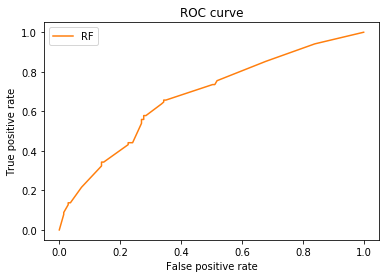

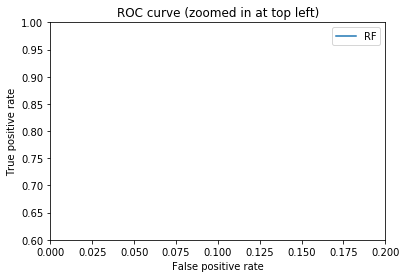

NameError: name 'average_precision_score' is not defined

In [470]:
#Plot ROC curve and Precision-Recall
from sklearn.metrics import roc_curve

y_pred_grd = rf.predict_proba(X_test)[:, 1]

X_test2 = dfo_test
y_pred_axis = rf.predict_proba(X_test2)[:,1]

fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# The random forest model by itself
plt.figure(1)
plt.plot(fpr_grd, tpr_grd, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grd, tpr_grd, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

y_score=y_pred_grd
average_precision = average_precision_score(y_test, y_score)

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [472]:
print('Precision:',precision_score(y_test, preds3))

print('Recall:',recall_score(y_test, preds3))

print('Accuracy:',accuracy_score(y_test,preds3))

Precision: 0.576923076923
Recall: 0.441176470588
Accuracy: 0.623430962343


In [ ]:
plt.hist(y_pred_grd)
plt.show()